## Введение

Задача классификации, определяющая, превышает ли значение СС50 медианное значение выборки. В рамках данного анализа будут использованы различные методы машинного обучения для решения данной задачи, а также выполнена оценка их производительности и интерпретация результатов.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Добавим данные в датафрейм
df = pd.read_csv('../../data/data.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
# Проверим загрузку данных
df.head(10)

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,Log_IC50,Log_CC50,Log_SI
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.830880,5.167539,3.336659
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-0.258989,1.686921,1.945910
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.410792,5.082288,-0.328504
3,1.705624,107.855654,39.266667,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.533931,4.680794,3.670376
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.674057,4.936422,0.262364
5,15.037911,30.075821,2.000000,5.758408,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.710574,3.403722,0.693147
6,18.908167,14.559288,0.770000,2.584472,2.584472,0.429649,0.429649,0.328539,36.564103,528.869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.939594,2.678229,-0.261365
7,28.773087,23.593931,0.820000,13.821880,13.821880,0.079845,-0.301260,0.217332,31.333333,695.089,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.359440,3.160990,-0.198451
8,50.057068,153.709268,3.070681,14.171614,14.171614,0.019123,-0.411828,0.187781,29.157895,763.123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.913164,5.035063,1.121899
9,6.400847,400.906360,39.266667,6.135893,6.135893,0.239226,0.239226,0.439915,36.400000,468.685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.856430,5.993728,3.670376


In [4]:
# Целевая переменная
target = 'CC50'

# Отделяем признаки от целевой переменной
X = df.drop(columns=[target, 'CC50', 'SI'], errors='ignore')
CC_median = df[target].median()
y = (df[target] > CC_median).astype(int)

In [5]:
# Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Классы (CC50 > медианы): {0: 502, 1: 499}


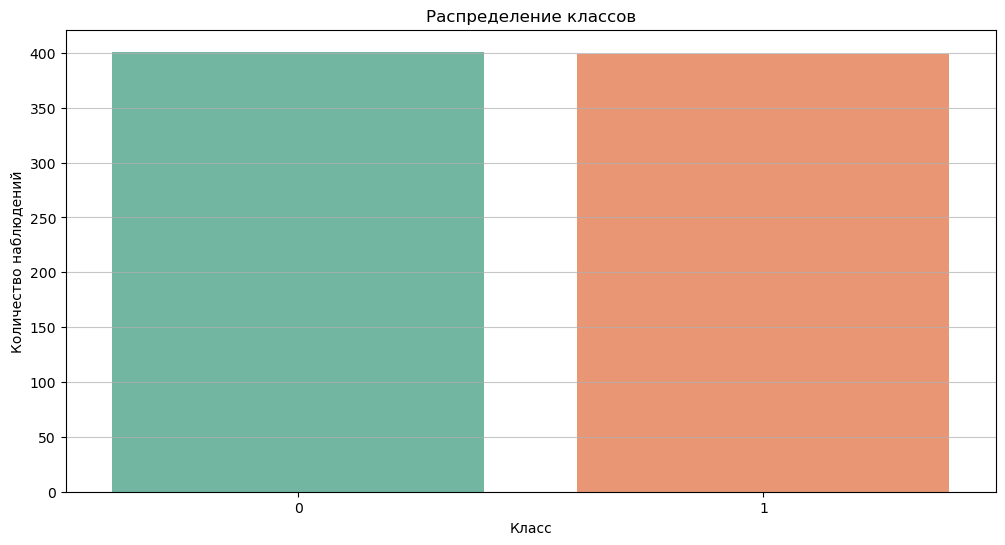

In [6]:
# Проверяем баланс классов
print("Классы (CC50 > медианы):", y.value_counts().to_dict())

# Визуализируем балансировку классов
plt.figure(figsize=(12, 6))
sns.countplot(x=y_train, palette="Set2")
plt.title("Распределение классов")
plt.xlabel('Класс')
plt.ylabel('Количество наблюдений')
plt.grid(axis='y', alpha=0.7)
plt.show()

In [7]:
# Напишем функцию для оценки моделей
def evaluate(y_true, y_pred, model_name):
    print(f"\nРезультаты для модели: {model_name}")
    print("Точность:", accuracy_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_pred))
    print("Матрица ошибок:\n", confusion_matrix(y_true, y_pred))


Результаты для модели: Логистическая Регрессия (CC50 > медианы)
Точность: 0.9850746268656716
F1-score: 0.9850746268656716
ROC AUC: 0.9850990099009901
Матрица ошибок:
 [[99  2]
 [ 1 99]]


<Figure size 800x600 with 0 Axes>

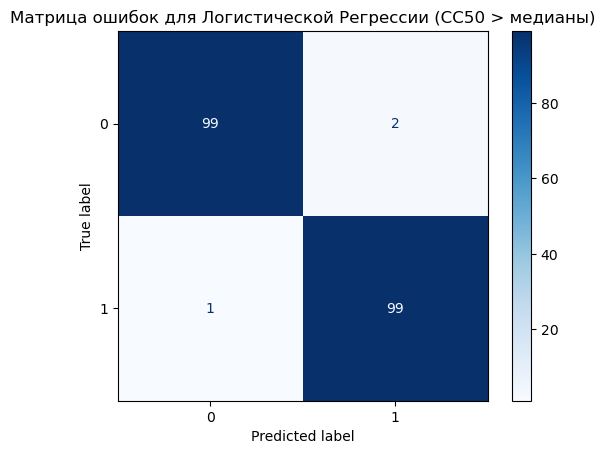

In [8]:
# Логистическая регрессия
log_params = {'C': [0.05, 0.5, 1.5, 5]}
log_model = GridSearchCV(LogisticRegression(max_iter=7000, solver='liblinear'), log_params, cv=4, scoring='f1')
log_model.fit(X_train, y_train)
y_pred_log = log_model.best_estimator_.predict(X_test)


# Вероятности положительных классов
probs = log_model.best_estimator_.predict_proba(X_test)[:, 1]

# Рассчитываем FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Оценим производительность моделей
evaluate(y_test, y_pred_log, "Логистическая Регрессия (CC50 > медианы)")

# Рассчитываем матрицу ошибок
cm = confusion_matrix(y_test, y_pred_log)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок для Логистической Регрессии (CC50 > медианы)')
plt.grid(False)
plt.show()

Продемонстрированы хорошие результаты с точностью в 0.985.
Матрица ошибок показывает небольшое количество ошибок классификации (2 FN и 1 FP), но в целом модель достаточно точна - ROC AUC: 0.985 указывает на хорошую способность различать классы.
Логистическая регрессия может быть использована в качестве базовой модели, однако, существуют модели, которые могут превзойти ее по производительности. На результат которых посмотрим далее.


Результаты для модели: Случайный Лес (CC50 > медианы)
Точность: 1.0
F1-score: 1.0
ROC AUC: 1.0
Матрица ошибок:
 [[101   0]
 [  0 100]]


<Figure size 800x600 with 0 Axes>

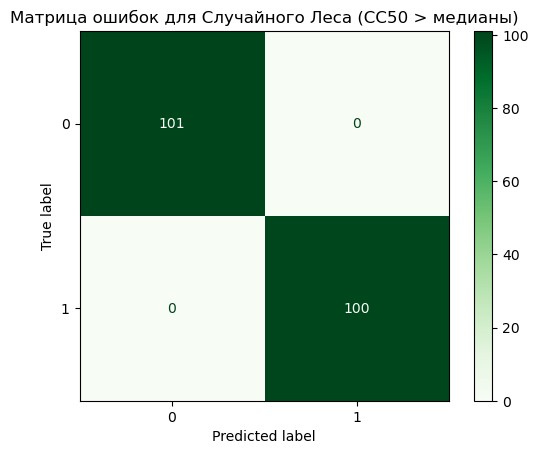

In [9]:
# Случайный лес
rf_params = {'n_estimators': [150, 250, 300], 'max_depth': [None, 15, 25]  }
rf_model = GridSearchCV(RandomForestClassifier(random_state=123), rf_params, cv=4, scoring='f1')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.best_estimator_.predict(X_test)

# Оценим производительность моделей
evaluate(y_test, y_pred_rf, "Случайный Лес (CC50 > медианы)")

# Вероятности положительного класса
probs = rf_model.best_estimator_.predict_proba(X_test)[:, 1]

# Рассчитываем FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Рассчитываем матрицу ошибок
cm = confusion_matrix(y_test, y_pred_rf)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Матрица ошибок для Случайного Леса (CC50 > медианы)')
plt.grid(False)
plt.show()

Случайный лес показал отличные результаты, достигнув совершенной точности, F1-score и ROC AUC: 1.0
Матрица ошибок не содержит ошибок классификации, что свидетельствует об
идеальной производительности на данном наборе данных
Вывод: Случайный лес является отличным выбором для задачи классификации CC50,
превосходя другие модели по производительности.



Результаты для модели: XGBoost (CC50 > медианы)
Точность: 0.9950248756218906
F1-score: 0.9949748743718593
ROC AUC: 0.995
Матрица ошибок:
 [[101   0]
 [  1  99]]


<Figure size 800x600 with 0 Axes>

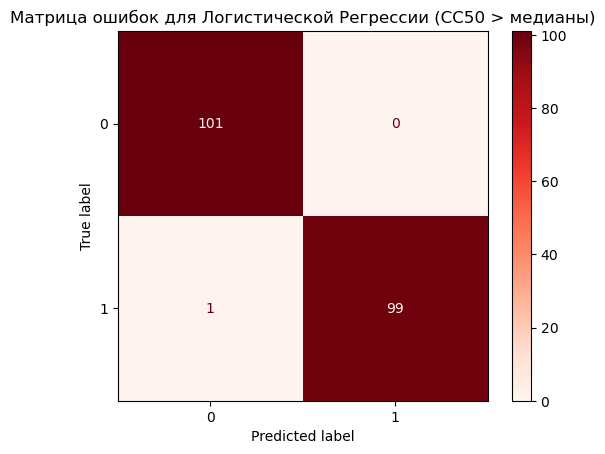

In [10]:
# Модель XGBoost
xgb_params = {
    'n_estimators': [150, 250, 350],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.15] 
}
xgb_model = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=123),
    xgb_params,
    cv=4,
    scoring='f1'
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.best_estimator_.predict(X_test)

# Оценим производительность моделей
evaluate(y_test, y_pred_xgb, "XGBoost (CC50 > медианы)")

# Вероятности положительного класса
probs = xgb_model.best_estimator_.predict_proba(X_test)[:, 1]

# Рассчитываем FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Рассчитываем матрицу ошибок
cm = confusion_matrix(y_test, y_pred_xgb)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title('Матрица ошибок для Логистической Регрессии (CC50 > медианы)')
plt.grid(False)
plt.show()

XGBoost показал почти идеальные результаты с точностью 0.995, F1-score 0.995, ROC AUC 0.995.
Матрица ошибок содержит небольшое количество ошибок классификации, но в целом модель очень точна.
XGBoost может служить отличной альтернативой, показав близкие к идеальным результаты в данной задаче.

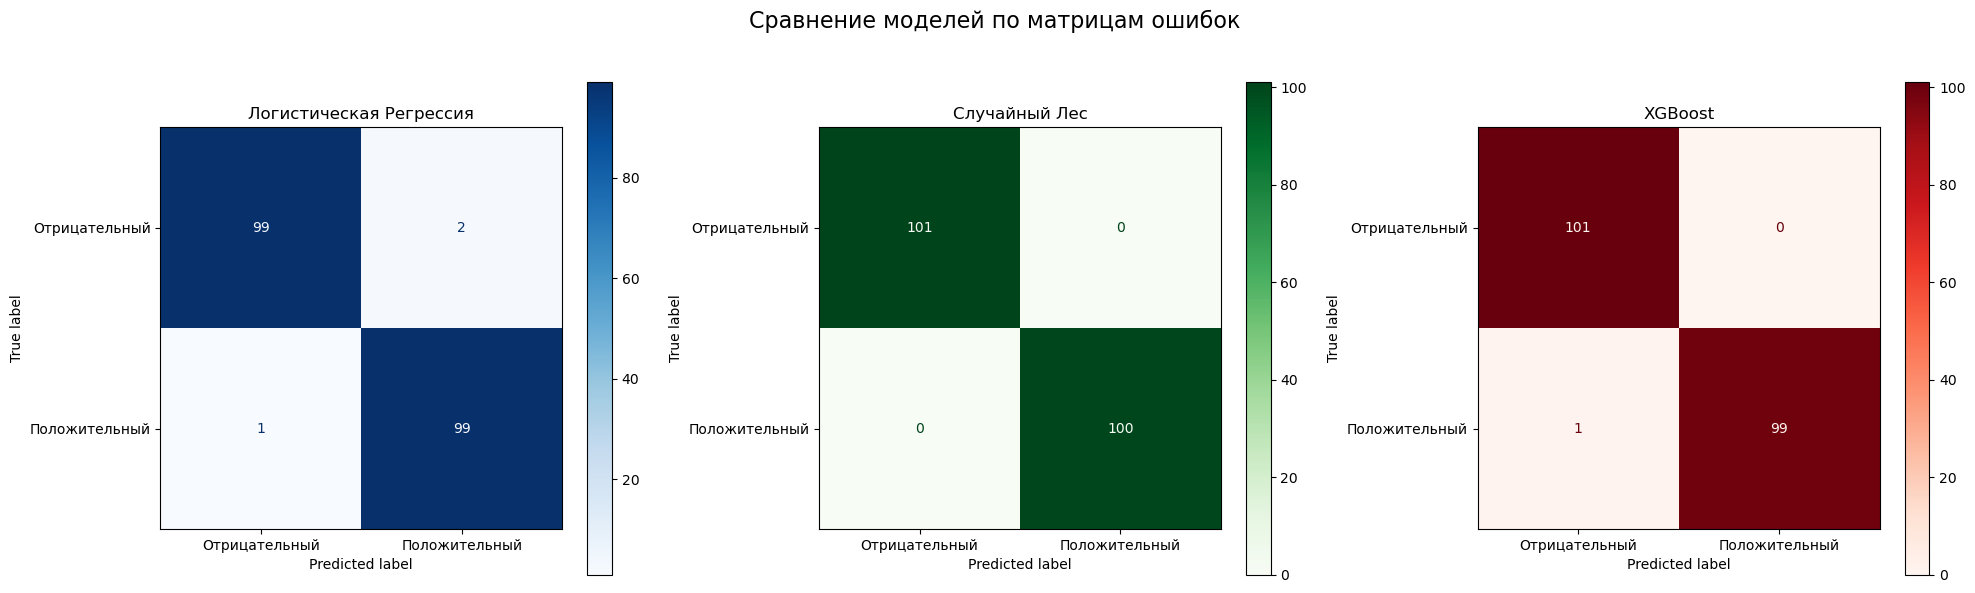

In [19]:
# Прогнозы для каждой модели
log_preds = log_model.best_estimator_.predict(X_test)
rf_preds = rf_model.best_estimator_.predict(X_test)
xgb_preds = xgb_model.best_estimator_.predict(X_test)
# Создаем фигуру для отображения матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Названия моделей и цветовые палитры
model_names = ["Логистическая Регрессия", "Случайный Лес", "XGBoost"]
predictions = [log_preds, rf_preds, xgb_preds]
colors = ['Blues', 'Greens', 'Reds']

# Проходим по каждой модели и строим матрицу ошибок
for ax, name, preds, color in zip(axes, model_names, predictions, colors):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Отрицательный', 'Положительный'])
    disp.plot(ax=ax, cmap=color, values_format='d')
    ax.title.set_text(name)
    
# Общие параметры графика
plt.suptitle('Сравнение моделей по матрицам ошибок', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Все три модели машинного обучения показали хорошие результаты в задаче классификации.

Случайный лес показал наилучшую производительность, достигнув идеальной точности на данном наборе данных.

XGBoost также показал отличные результаты, что делает его хорошей альтернативой.

Выбор конкретной модели зависит от требований к интерпретируемости, вычислительной мощности и объему данных.

Результаты позволяют говорить об успешном применении машинного обучения для классификации значений CC50 относительно медианы выборки.